# Desarrollo y comparación de algoritmos regresivos para la estimación de edades estelares

### 1. Carga y procesado del dataset

In [1]:
import pandas as pd
import numpy as np

# Se carga el dataset como un dataframe.
df = pd.read_csv('/Users/jarmireciomartinez/Doctorado_Python/Pruebas_regresion/gyro_tot_v20180801.txt', sep="\t", header=0)

# Se eliminan las filas con valores NULL/NA.
df = df.dropna()

### 2. Selección de características clave

In [2]:
# Se crea un segundo dataset con las características a utilizar.
df_2 = df[['Seq', 'M', 'R', 'Teff','L','Meta','logg','Prot','Age']]

# Se definen las variables para entrenar y probar el modelo, además de la variable etiqueta.
Y = np.array(df_2['Age']) #Predecir Age, etiqueta
#X = np.array(df_2[['M']]) #A través de la masa
X = np.array(df[['Seq', 'M', 'R', 'Teff','L','Meta','logg','Prot']]) #A través de las demás columnas

from sklearn import preprocessing
from sklearn.preprocessing import normalize

X_norm = preprocessing.normalize(X, norm='l2') #Normalización del conjunto de características

### 2.1 Observaciones:

- El algoritmo lineal de regresión, presenta mejores resultados con todas las características sin normalizar.
- El algoritmo SVR, presenta mejores resultados con X = np.array(df_2[['M']]) que con el resto de características juntas y normalizadas.
- El algoritmo kNN, presenta mejores resultados con X = np.array(df_2[['M']]) que con el resto de características juntas y normalizadas.
- El algoritmo de árboles de decisión, presenta menor MAE con todas las características sin normalizar pero peor score.
- El algoritmo de regresión gaussiana, presenta mejores resultados con default kernel que con la suma de kernels y con las características normalizadas.
- El algoritmo SGD presenta mejor score y MAE con X = np.array(df_2[['M']]) que con todas las características normalizadas y sin normalizar.

### 3. Reparto de casos para conjunto de entrnamiento y pruebas

In [3]:
from sklearn.model_selection import train_test_split

# Se establece el 20% de los datos como conjunto de test, siendo el 80% restante el conjunto de entrenamiento.
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.2)

### 4. Importación de los módulos necesarios para cada modelo de regresión

In [100]:
# Módulos para los modelos
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Sum, ConstantKernel, ExpSineSquared
from sklearn.linear_model import SGDRegressor

# Módulos para las métricas
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_error

### 5. Definición y construcción de los modelos

In [117]:
# Definición de los regresores

names = ["Multiple Linear Regression", "Linear SVM", "RBF SVM", "kNN", "Decision Tree", 
         "Gaussian Process", "SGD"]
classifiers = [
    linear_model.LinearRegression(),
    SVR(kernel='linear', C=1.0, epsilon=0.2),
    SVR(kernel='rbf', C=1.0, epsilon=0.2),
    KNeighborsRegressor(n_neighbors=10, weights='distance'),
    DecisionTreeRegressor(criterion='mse'),
    GaussianProcessRegressor(kernel= Sum(ConstantKernel(2), RBF())),
    SGDRegressor()]

In [118]:
# Entrenamiento de los modelos y obtención de los valores de score y conjuntos predecidos

Y_pred = []

for name, clf in zip(names, classifiers):
    clf.fit(X_train, Y_train)
    Y_pred_aux = clf.predict(X_test)
    Y_pred.append(Y_pred_aux)

In [119]:
# Obtención de las métricas: Mean squared error, Coefficient of determination, Max error and Mean absolute error.

MSE = []
DET = []
MAX = []
MAE = []

for x in Y_pred:
    mse = mean_squared_error(Y_test, x)
    MSE.append(mse)
    det = r2_score(Y_test, x)
    DET.append(det)
    max_e = max_error(Y_test, x)
    MAX.append(max_e)
    mae = mean_absolute_error(Y_test, x)
    MAE.append(mae)

### 6. Comparativa de resultados

In [120]:
#Se genera un dataframe con los resultados

df_3 = pd.DataFrame()
df_3['Name'] = names
df_3['Mean square error'] = MSE
df_3['Determination'] = DET
df_3['Max error'] = MAX
df_3['Mean absolute error'] = MAE
df_3

,Name,Mean square error,Determination,Max error,Mean absolute error
0,Multiple Linear Regression,1.205232,0.785637,3.874510,0.771360
1,Linear SVM,6.086996,-0.082633,10.529300,1.684018
2,RBF SVM,6.090397,-0.083238,10.538147,1.683654
3,kNN,3.628027,0.354719,8.718099,1.291369
4,Decision Tree,2.228787,0.603588,7.712200,0.893947
5,Gaussian Process,5.618200,0.000747,9.963446,1.700901
6,SGD,5.639831,-0.003101,9.976092,1.714943


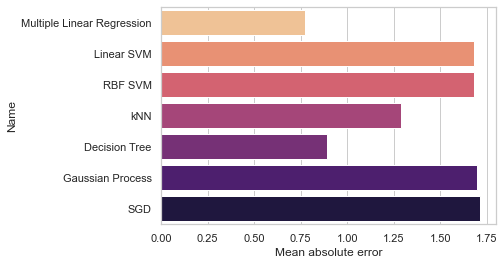

In [121]:
#Se representa de forma gráfica

import seaborn as sns

ax = sns.barplot(y="Name", x="Mean absolute error", data=df_3, palette="magma_r")